In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,calculate_shift_value, plot_predictions


In [4]:
sheet = pd.read_excel('data_input/低硫燃料油裂解价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['新加坡0.5%低硫燃料油裂解价差'].last_valid_index()


sheet = sheet.rename(columns={'全球经济惊喜指数': '全球经济惊喜指数（同花顺）'})

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,新加坡0.5%低硫燃料油裂解价差,WTI连1合约价格（路透）,PX-WTI价差,新加坡航空煤油裂解价差,布伦特迪拜掉期 EFS,美国经济惊喜指数超季节性/3年,中美经济预期差指数,欧元区经济惊喜指数超季节性/3年,LME铜价,Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差,...,集装箱船发运量/中国-美国同差,FBX全球集装箱运价指数20日环比,GPR地缘风险指数/自动/7DMA,新加坡10ppm柴油裂解,brent-dubai价差,VLCC运费（鹿特丹-新加坡）（数据调整）超季节性/3年,Brent原油期货连1合约价格/路透,天然气TTF连1价格,主要国家发往美国集装箱船数量同差,主要低硫出口地燃料油出口量当月环比变化+中国低硫产量环比变化-（新加坡+中国）低硫消费量环比变化
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/化工/eta/PX-WTI价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/化工/eta/PX-WTI价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/化工/eta/PX-WTI价差_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,预测值
19,2025-11-06,395.8
18,2025-11-07,392.6
17,2025-11-10,403.6
16,2025-11-11,405.4
15,2025-11-12,401.9


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/新加坡航空煤油裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/新加坡航空煤油裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/新加坡航空煤油裂解价差_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['新加坡航空煤油裂解价差'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()

,Date,新加坡航空煤油裂解价差_预测
20,2025-11-07,22.29
19,2025-11-10,22.86
18,2025-11-11,19.44
17,2025-11-12,20.97
16,2025-11-13,19.52


In [7]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/铜/eta/LME铜价_合并数据.xlsx")
]


file_path3 = None
for path in file_paths3:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path3 = path
        break

if file_path3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.drop(columns=['真实值'])
    sheet3 = sheet3.dropna()
    sheet3 = sheet3.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet3.head()

,Date,预测值
20,2025-11-07,10695.7
19,2025-11-10,10669.5
18,2025-11-11,10673.2
17,2025-11-12,10675.2
16,2025-11-13,10678.7


In [8]:
# 尝试多个可能的文件路径
file_paths4 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/新加坡10ppm柴油裂解_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/新加坡10ppm柴油裂解_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/新加坡10ppm柴油裂解_合并数据.xlsx")
]


file_path4 = None
for path4 in file_paths4:
    if os.path.isfile(path4):  # 确保是文件而不是目录
        file_path4 = path4
        break

if file_path4 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.ExcelFile(file_path4).parse('Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['真实值'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,预测值
30,2025-11-07,23.6
29,2025-11-10,23.0
28,2025-11-11,23.1
27,2025-11-12,22.9
26,2025-11-13,23.1


In [9]:
# 尝试多个可能的文件路径
file_paths5 = [
    os.path.expanduser("~/Desktop/X-BASE/化工/eta/PX-WTI价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/化工/eta/PX-WTI价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/化工/eta/PX-WTI价差_合并数据.xlsx")
]


file_path5 = None
for path in file_paths5:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path5 = path
        break

if file_path5 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet5 = pd.ExcelFile(file_path5).parse('Sheet1')
    sheet5['Date'] = pd.to_datetime(sheet5['Date'], errors='coerce')
    sheet5 = sheet5.drop(columns=['真实值'])
    sheet5 = sheet5.dropna()
    sheet5 = sheet5.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet5.head()

,Date,预测值
19,2025-11-06,395.8
18,2025-11-07,392.6
17,2025-11-10,403.6
16,2025-11-11,405.4
15,2025-11-12,401.9


In [10]:
# 尝试多个可能的文件路径
file_paths6 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
]

file_path6 = None
for path in file_paths6:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path6 = path
        break

if file_path6 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet6 = pd.ExcelFile(file_path6).parse('Sheet1')
    sheet6['Date'] = pd.to_datetime(sheet6['Date'], errors='coerce')
    sheet6 = sheet6.sort_values('Date', ascending=True)
    sheet6['布伦特原油期货价格'] = sheet6['布伦特原油期货价格'].fillna(sheet6['Brent原油期货价格预测'])
    sheet6 = sheet6.drop(columns=['Brent原油期货价格预测'])
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet6.head()

,Date,布伦特原油期货价格
650,2023-06-02,76.13
649,2023-06-05,76.71
648,2023-06-06,76.29
647,2023-06-07,76.95
646,2023-06-08,75.96


In [11]:
# 尝试多个可能的文件路径
file_paths7 = [
    os.path.expanduser("~/Desktop/X-BASE/天然气/eta/天然气TTF连1价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/天然气/eta/天然气TTF连1价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/天然气/eta/天然气TTF连1价格_合并数据.xlsx")
]

file_path7 = None
for path in file_paths7:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path7 = path
        break

if file_path7 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet7 = pd.ExcelFile(file_path7).parse('Sheet1')
    sheet7['Date'] = pd.to_datetime(sheet7['Date'], errors='coerce')
    sheet7 = sheet7.sort_values('Date', ascending=True)
    sheet7['实际值'] = sheet7['实际值'].fillna(sheet7['天然气TTF连1价格'])
    sheet7 = sheet7.drop(columns=['天然气TTF连1价格'])
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet7.head()

,Date,实际值
748,2023-01-02,76.61
747,2023-01-03,72.60
746,2023-01-04,65.07
745,2023-01-05,72.25
744,2023-01-06,69.50


In [12]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['PX-WTI价差'] = sheet_daily['PX-WTI价差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '新加坡航空煤油裂解价差_预测']],
    on='Date',
    how='left'
)
sheet_daily['新加坡航空煤油裂解价差'] = sheet_daily['新加坡航空煤油裂解价差'].fillna(sheet_daily['新加坡航空煤油裂解价差_预测'])
sheet_daily = sheet_daily.drop(columns=['新加坡航空煤油裂解价差_预测'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['LME铜价'] = sheet_daily['LME铜价'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily = sheet_daily.rename(columns={'Singapore 10ppm gasoil crack': '新加坡10ppm柴油裂解'})
sheet_daily['新加坡10ppm柴油裂解'] = sheet_daily['新加坡10ppm柴油裂解'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet5[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['PX-WTI价差'] = sheet_daily['PX-WTI价差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet6[['Date', '布伦特原油期货价格']],
    on='Date',
    how='left'
)
sheet_daily['Brent原油期货连1合约价格/路透'] = sheet_daily['Brent原油期货连1合约价格/路透'].fillna(sheet_daily['布伦特原油期货价格'])
sheet_daily = sheet_daily.drop(columns=['布伦特原油期货价格'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet7[['Date', '实际值']],
    on='Date',
    how='left'
)
sheet_daily['天然气TTF连1价格'] = sheet_daily['天然气TTF连1价格'].fillna(sheet_daily['实际值'])
sheet_daily = sheet_daily.drop(columns=['实际值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [13]:
sheet.columns

Index(['新加坡0.5%低硫燃料油裂解价差', 'WTI连1合约价格（路透）', 'PX-WTI价差', '新加坡航空煤油裂解价差',
       '布伦特迪拜掉期 EFS', '美国经济惊喜指数超季节性/3年', '中美经济预期差指数', '欧元区经济惊喜指数超季节性/3年',
       'LME铜价', 'Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差', '低硫燃料油EW价差',
       '集装箱船发运量/中国-美国同差', 'FBX全球集装箱运价指数20日环比', 'GPR地缘风险指数/自动/7DMA',
       '新加坡10ppm柴油裂解', 'brent-dubai价差', 'VLCC运费（鹿特丹-新加坡）（数据调整）超季节性/3年',
       'Brent原油期货连1合约价格/路透', '天然气TTF连1价格', '主要国家发往美国集装箱船数量同差',
       '主要低硫出口地燃料油出口量当月环比变化+中国低硫产量环比变化-（新加坡+中国）低硫消费量环比变化'],
      dtype='object')

In [14]:
################################# 处理缺失值 #################################
fill_methods = {
'WTI连1合约价格（路透）': 'interpolate', 
'PX-WTI价差' : 'interpolate' ,
'新加坡航空煤油裂解价差': 'interpolate', 
'布伦特迪拜掉期 EFS': 'interpolate',
'美国经济惊喜指数超季节性/3年': 'interpolate',
'中美经济预期差指数': 'interpolate',
'欧元区经济惊喜指数超季节性/3年': 'interpolate',
'LME铜价': 'interpolate',
'Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差': 'interpolate',
'低硫燃料油EW价差': 'interpolate',
'集装箱船发运量/中国-美国同差':'interpolate',
'FBX全球集装箱运价指数20日环比':'interpolate',
'GPR地缘风险指数/自动/7DMA':'interpolate',
'PX-WTI价差':'interpolate',
'新加坡10ppm柴油裂解':'interpolate',
'brent-dubai价差':'interpolate',
'VLCC运费（鹿特丹-新加坡）（数据调整）超季节性/3年':'interpolate',
'Brent原油期货连1合约价格/路透':'interpolate',
'天然气TTF连1价格':'interpolate',
'主要国家发往美国集装箱船数量同差':'interpolate',
'主要低硫出口地燃料油出口量当月环比变化+中国低硫产量环比变化-（新加坡+中国）低硫消费量环比变化':'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['WTI连1合约价格（路透）_提前20天'] = sheet['WTI连1合约价格（路透）'].shift(20)
sheet['布伦特迪拜掉期 EFS_提前20天'] = sheet['布伦特迪拜掉期 EFS'].shift(20)
sheet['美国经济惊喜指数超季节性/3年_提前20天'] = sheet['美国经济惊喜指数超季节性/3年'].shift(20)
sheet['中美经济预期差指数_提前20天'] = sheet['中美经济预期差指数'].shift(20)
sheet['欧元区经济惊喜指数超季节性/3年_提前70天'] = sheet['欧元区经济惊喜指数超季节性/3年'].shift(70)
shift_value = calculate_shift_value(sheet, 'Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差', -379,last_day_index=pd.Timestamp('2025-05-26'), default_shift=20)
sheet['Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差_提前20天'] = sheet['Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差'].shift(shift_value)
shift_value = calculate_shift_value(sheet, '低硫燃料油EW价差', 30.19,last_day_index=pd.Timestamp('2025-05-26'), default_shift=20)
sheet['低硫燃料油EW价差_提前20天'] = sheet['低硫燃料油EW价差'].shift(shift_value)
sheet['集装箱船发运量/中国-美国同差_提前22天'] = sheet['集装箱船发运量/中国-美国同差'].shift(15)
sheet['FBX全球集装箱运价指数20日环比_提前20天'] = sheet['FBX全球集装箱运价指数20日环比'].shift(20)
sheet['GPR地缘风险指数/自动/7DMA_提前20天'] = sheet['GPR地缘风险指数/自动/7DMA'].shift(20)
sheet['新加坡10ppm柴油裂解_提前5天'] = sheet['新加坡10ppm柴油裂解'].shift(5)
#sheet['brent-dubai价差_提前5天'] = sheet['brent-dubai价差'].shift(5)
sheet['VLCC运费（鹿特丹-新加坡）（数据调整）超季节性/3年_提前10天'] = sheet['brent-dubai价差'].shift(10)
sheet['Brent原油期货连1合约价格/路透_提前5天'] = sheet['Brent原油期货连1合约价格/路透'].shift(5)
sheet['主要国家发往美国集装箱船数量同差_提前10天'] = sheet['主要国家发往美国集装箱船数量同差'].shift(10)

sheet['中美经济预期差指数_提前20天_逆序'] = reverse_column(sheet, '中美经济预期差指数_提前20天')
sheet['Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差_提前20天_逆序'] = reverse_column(sheet, 'Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差_提前20天')
sheet['主要低硫出口地燃料油出口量当月环比变化+中国低硫产量环比变化_逆序'] = reverse_column(sheet, '主要低硫出口地燃料油出口量当月环比变化+中国低硫产量环比变化-（新加坡+中国）低硫消费量环比变化')


# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in [
#    'brent-dubai价差_提前5天',
    '新加坡10ppm柴油裂解_提前5天'
    ]:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-09-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['新加坡0.5%低硫燃料油裂解价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

未找到Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差为-379的记录，使用默认shift值20
在2025年4月没有找到低硫燃料油EW价差为30.19的记录


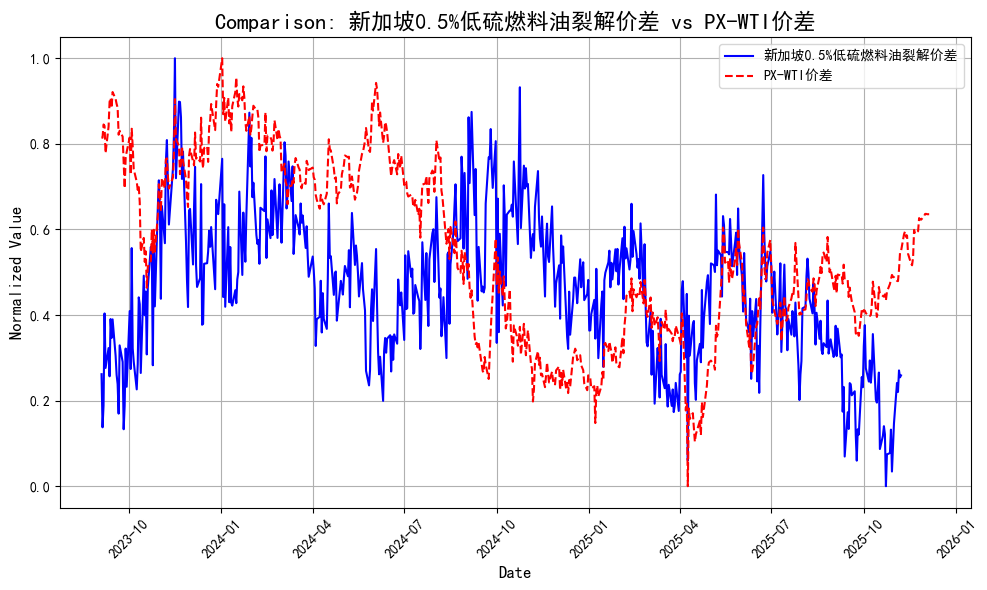

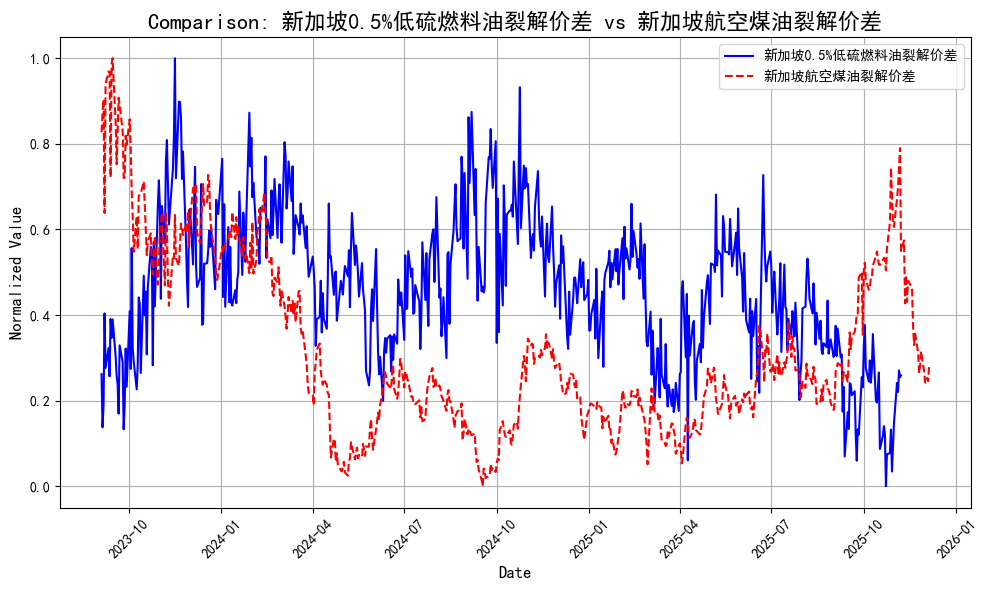

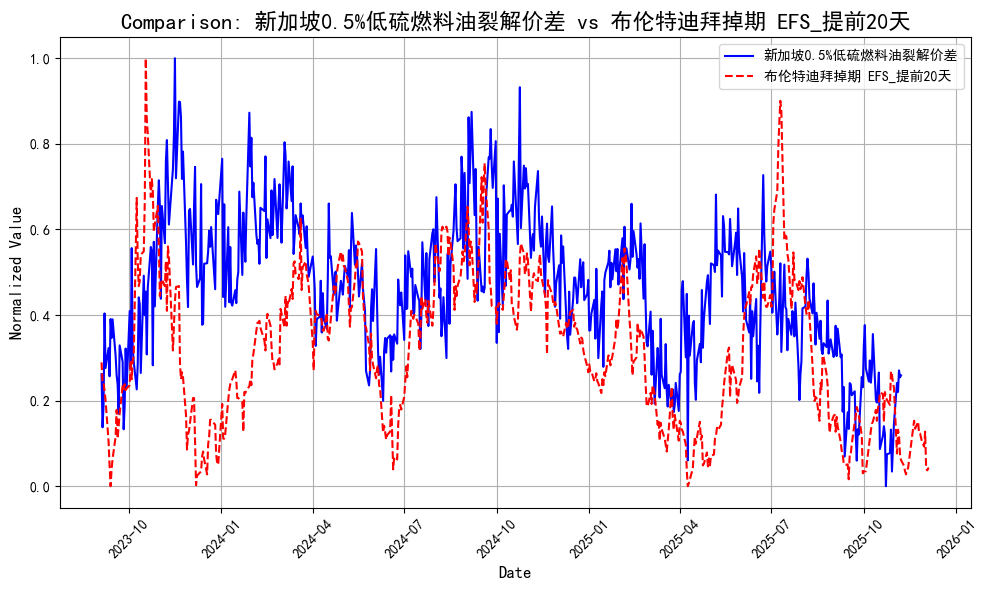

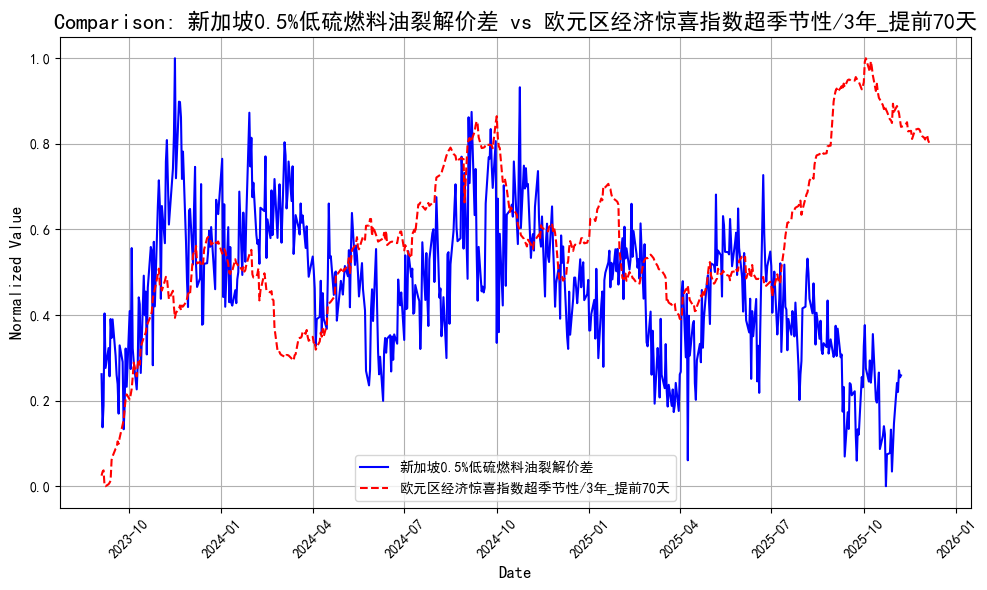

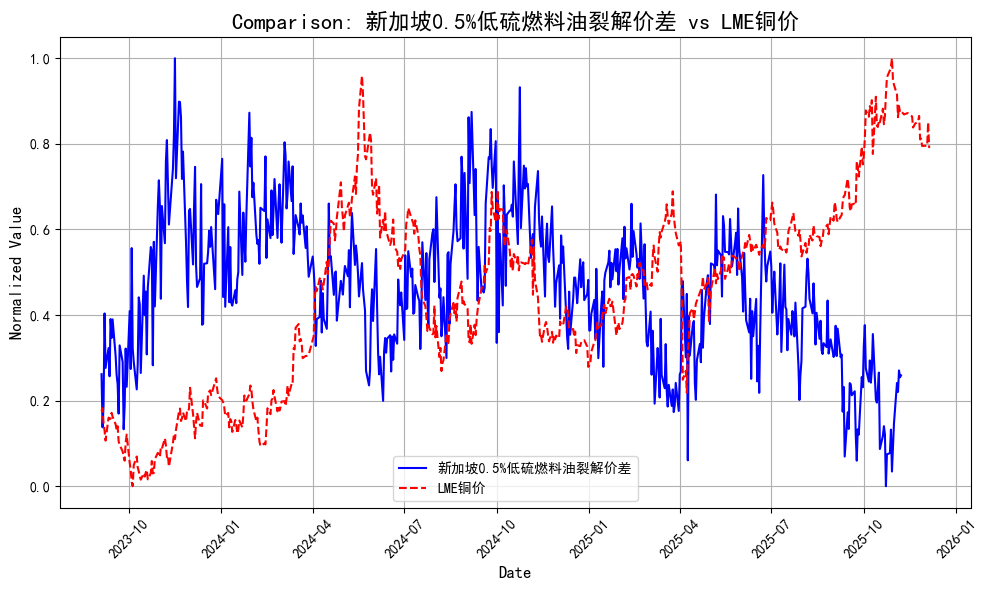

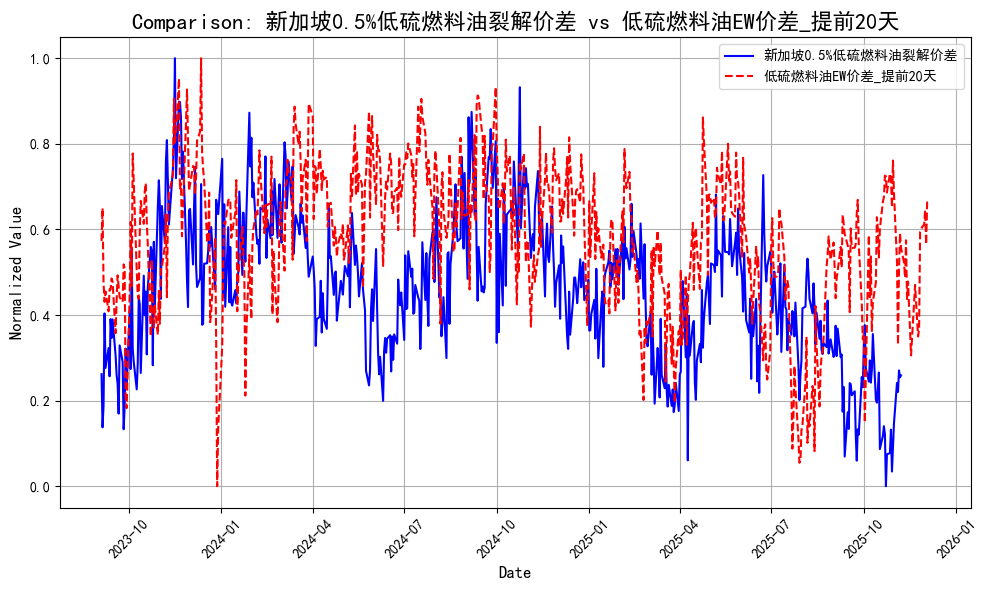

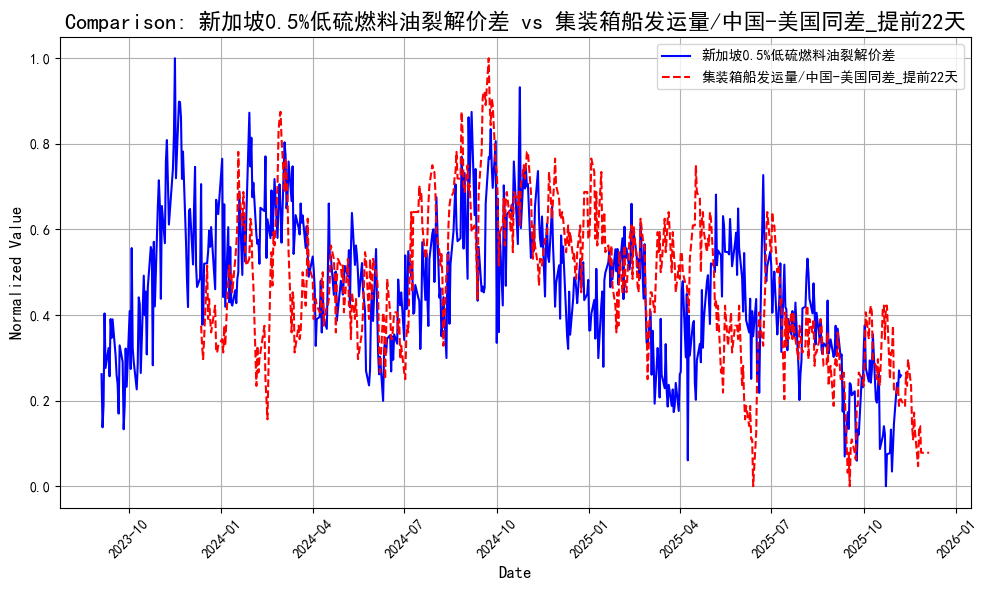

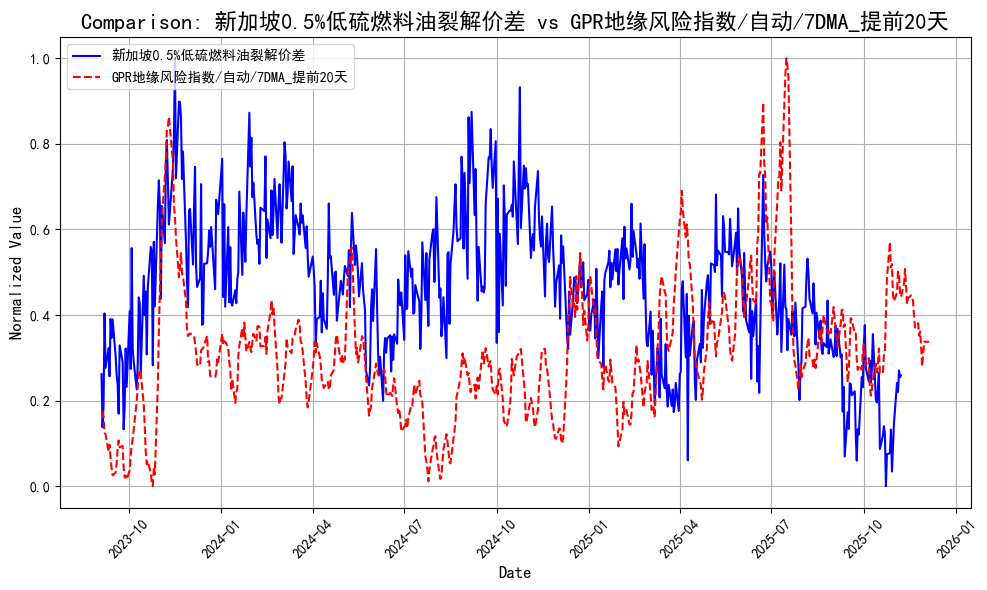

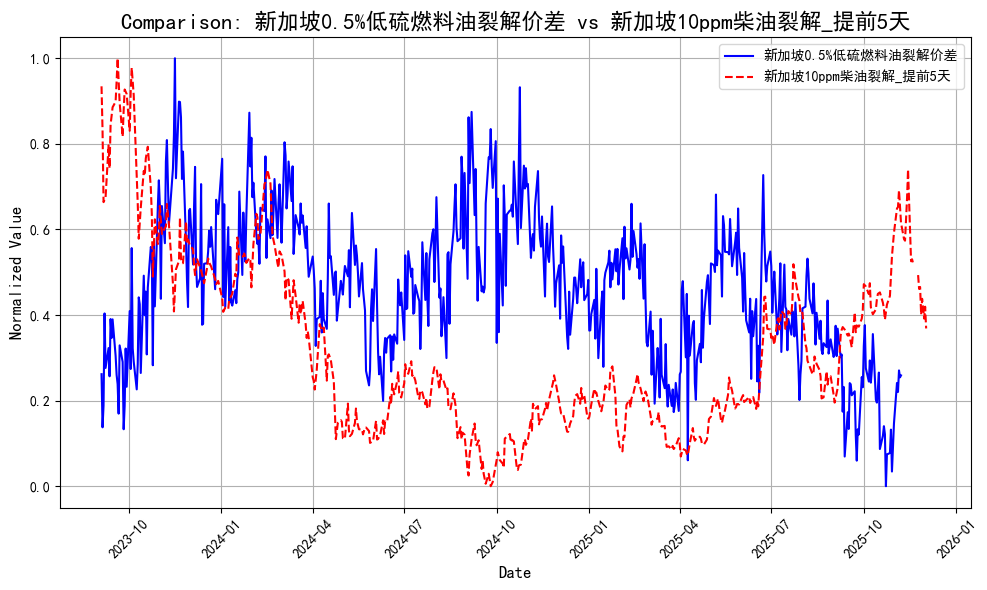

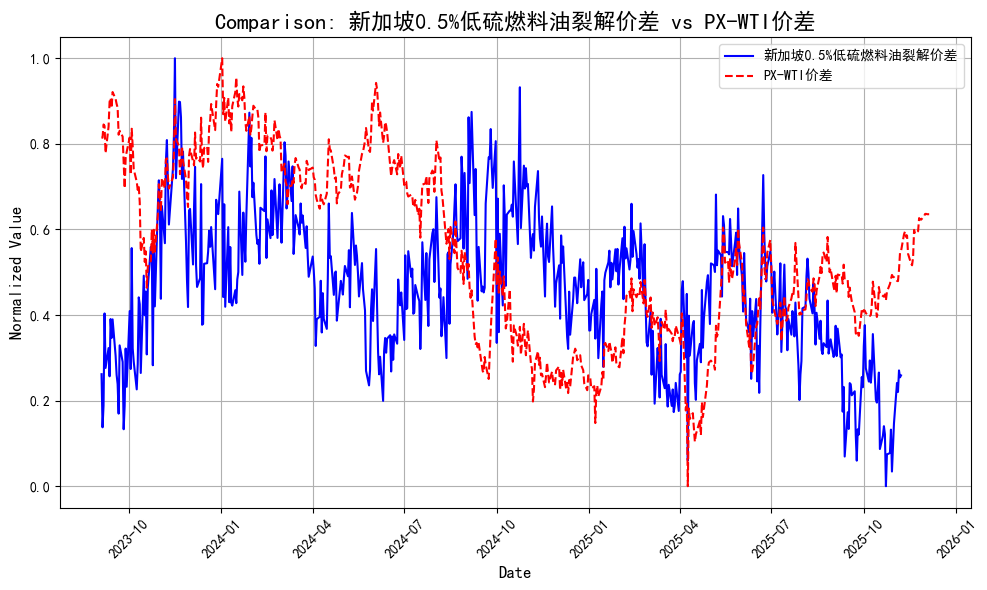

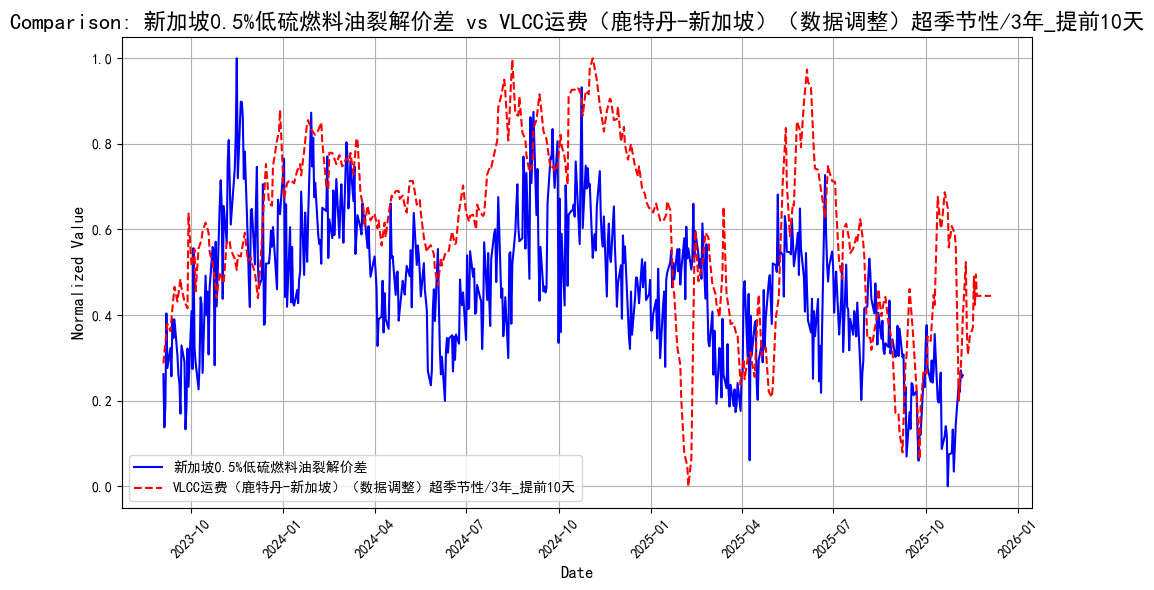

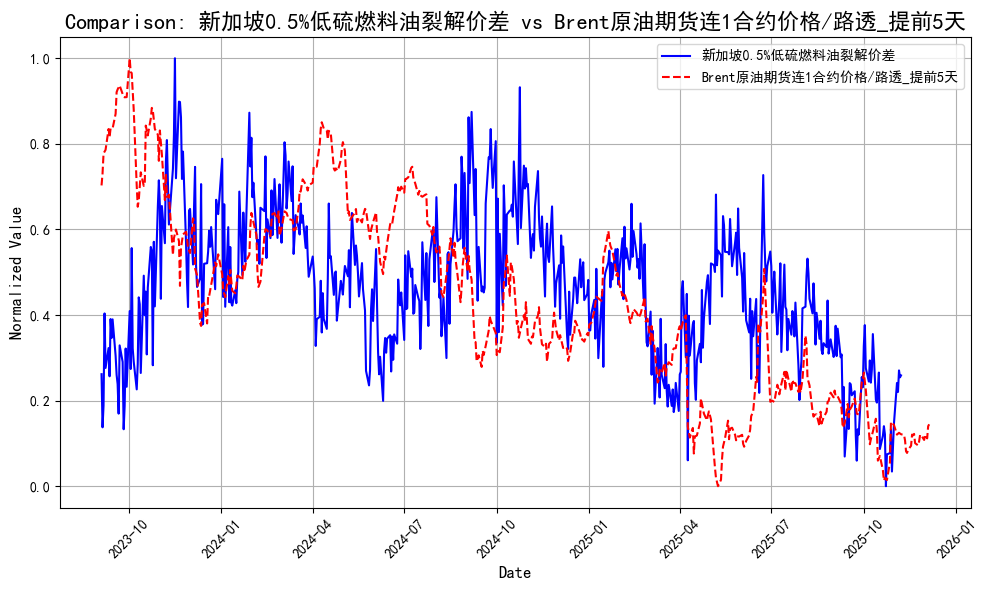

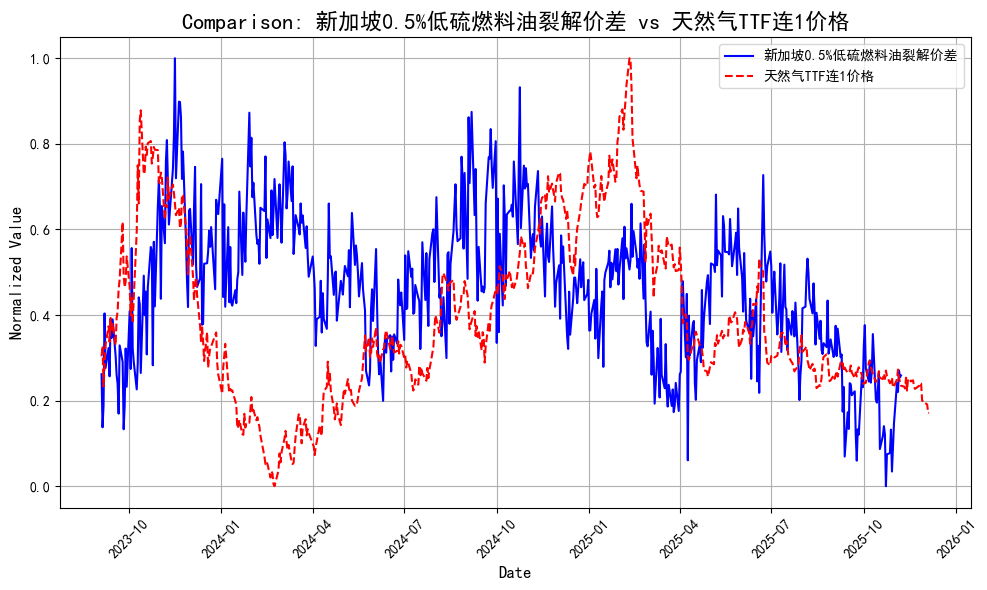

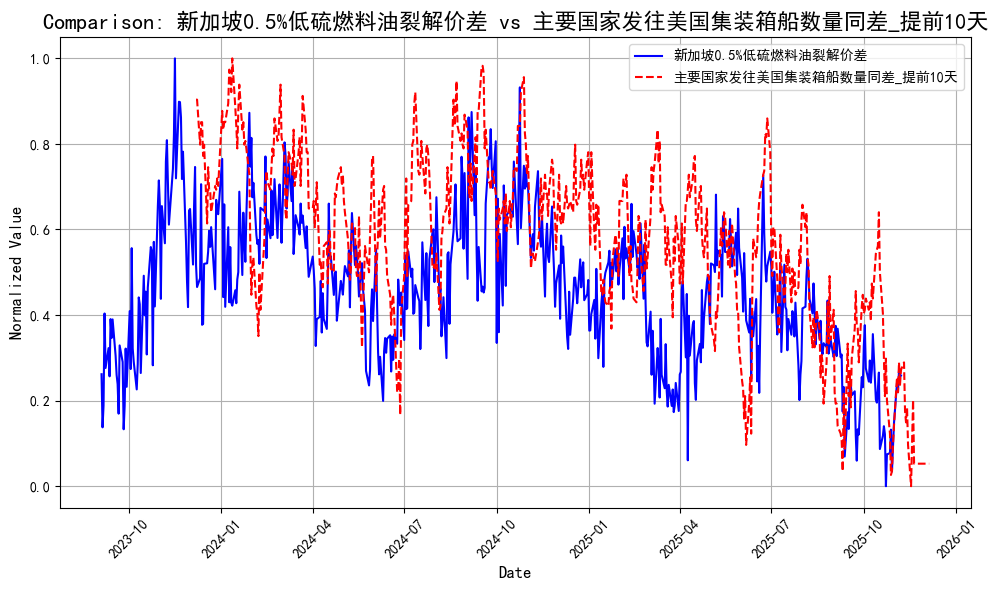

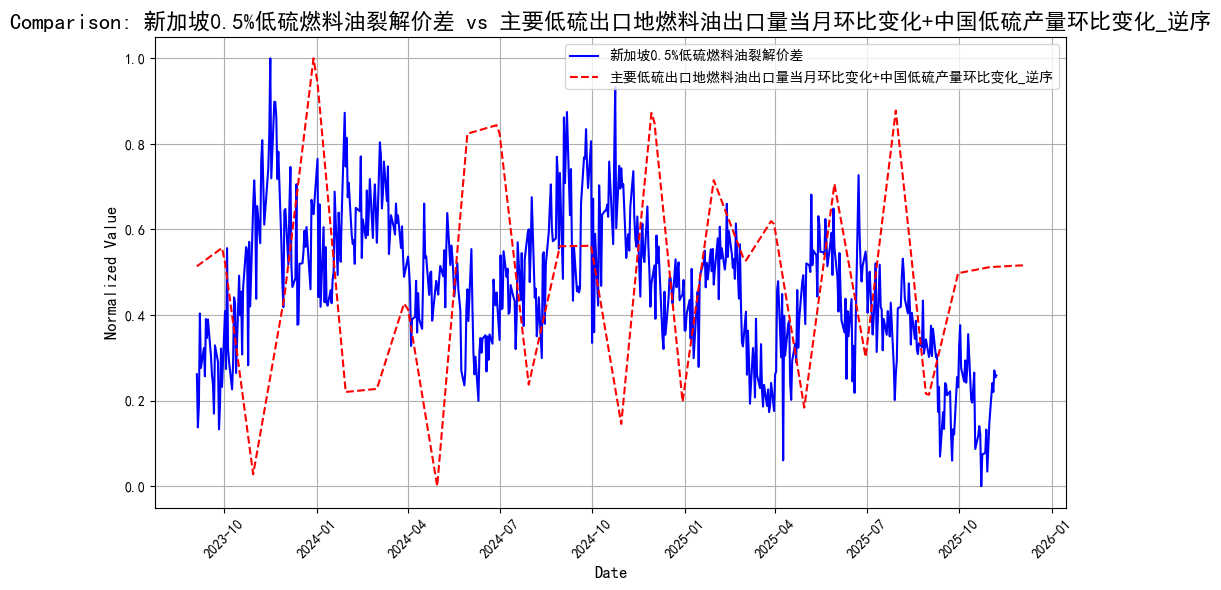

In [15]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='新加坡0.5%低硫燃料油裂解价差', 
    compare_cols=[
#        'WTI连1合约价格（路透）_提前20天',
        'PX-WTI价差',
        '新加坡航空煤油裂解价差',
        '布伦特迪拜掉期 EFS_提前20天',
#        '美国经济惊喜指数超季节性/3年_提前20天',
#        '中美经济预期差指数_提前20天_逆序',
        '欧元区经济惊喜指数超季节性/3年_提前70天',
        'LME铜价',
#        'Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差_提前20天_逆序',
        '低硫燃料油EW价差_提前20天',
        '集装箱船发运量/中国-美国同差_提前22天',
#        'FBX全球集装箱运价指数20日环比_提前20天',
        'GPR地缘风险指数/自动/7DMA_提前20天',
        '新加坡10ppm柴油裂解_提前5天',
        'PX-WTI价差',
#        'brent-dubai价差',
        'VLCC运费（鹿特丹-新加坡）（数据调整）超季节性/3年_提前10天',
        'Brent原油期货连1合约价格/路透_提前5天',
        '天然气TTF连1价格',
        '主要国家发往美国集装箱船数量同差_提前10天',
        '主要低硫出口地燃料油出口量当月环比变化+中国低硫产量环比变化_逆序'
        ]
)

In [16]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
#        'WTI连1合约价格（路透）_提前20天',
        'PX-WTI价差',
#        '新加坡航空煤油裂解价差',
        '布伦特迪拜掉期 EFS_提前20天',
#        '美国经济惊喜指数超季节性/3年_提前20天',
#        '中美经济预期差指数_提前20天_逆序',
        '欧元区经济惊喜指数超季节性/3年_提前70天',
        'LME铜价',
#        'Kpler-新加坡、马来西亚、印度尼西亚低硫燃料油浮仓12周环差_提前20天_逆序',
        '低硫燃料油EW价差_提前20天',
        '集装箱船发运量/中国-美国同差_提前22天',
#        'FBX全球集装箱运价指数20日环比_提前20天',
        'GPR地缘风险指数/自动/7DMA_提前20天',
        '新加坡10ppm柴油裂解_提前5天',
        'PX-WTI价差',
#        'brent-dubai价差',
        'VLCC运费（鹿特丹-新加坡）（数据调整）超季节性/3年_提前10天',
        'Brent原油期货连1合约价格/路透_提前5天',
        '天然气TTF连1价格',
        '主要国家发往美国集装箱船数量同差_提前10天',
        '主要低硫出口地燃料油出口量当月环比变化+中国低硫产量环比变化_逆序'
]

predict_column = '新加坡0.5%低硫燃料油裂解价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.019076895067287096, 
    'max_depth': 10, 
    'min_child_weight':0.3, 
    'subsample': 0.8915228866126468, 
    'colsample_bytree': 0.9633030498557493, 
    'gamma': 0.04016694339000221, 
    'reg_alpha': 0.3933350939645253, 
    'reg_lambda': 0.7903681660674629,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}


num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:4.18608	train-rmse:2.16342


[500]	eval-rmse:2.20226	train-rmse:0.14288


[1000]	eval-rmse:2.19210	train-rmse:0.13880


[1500]	eval-rmse:2.18757	train-rmse:0.13746


[1999]	eval-rmse:2.18818	train-rmse:0.13706


训练集 MSE (DMatrix): 0.0213, 训练集 R² (DMatrix): 0.9959
测试集 MSE (DMatrix): 4.7881, 测试集 R² (DMatrix): -2.701


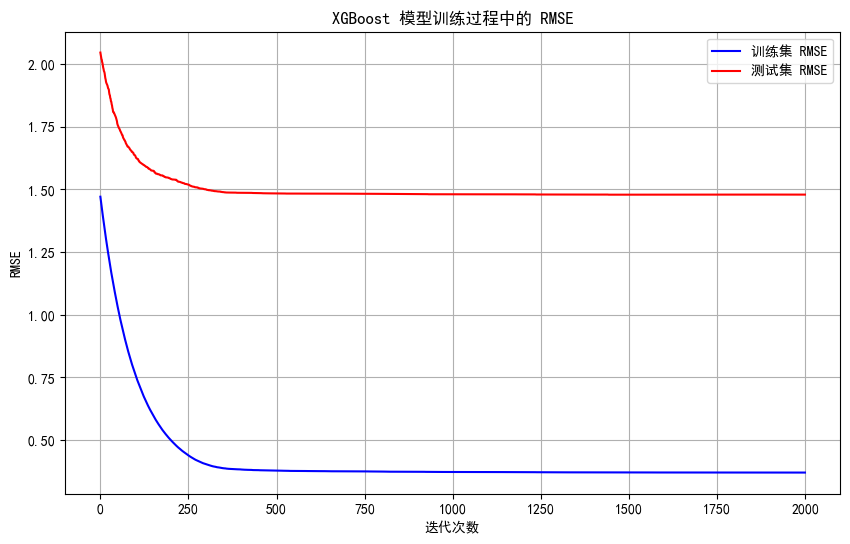

In [17]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:2.20355


[500]	train-rmse:0.14511


[1000]	train-rmse:0.14067


[1500]	train-rmse:0.13877


[1999]	train-rmse:0.13801


全部数据 MSE: 0.0215, 全部数据 R²: 0.9961


Gap between last actual value and first prediction: -0.3199960746765136


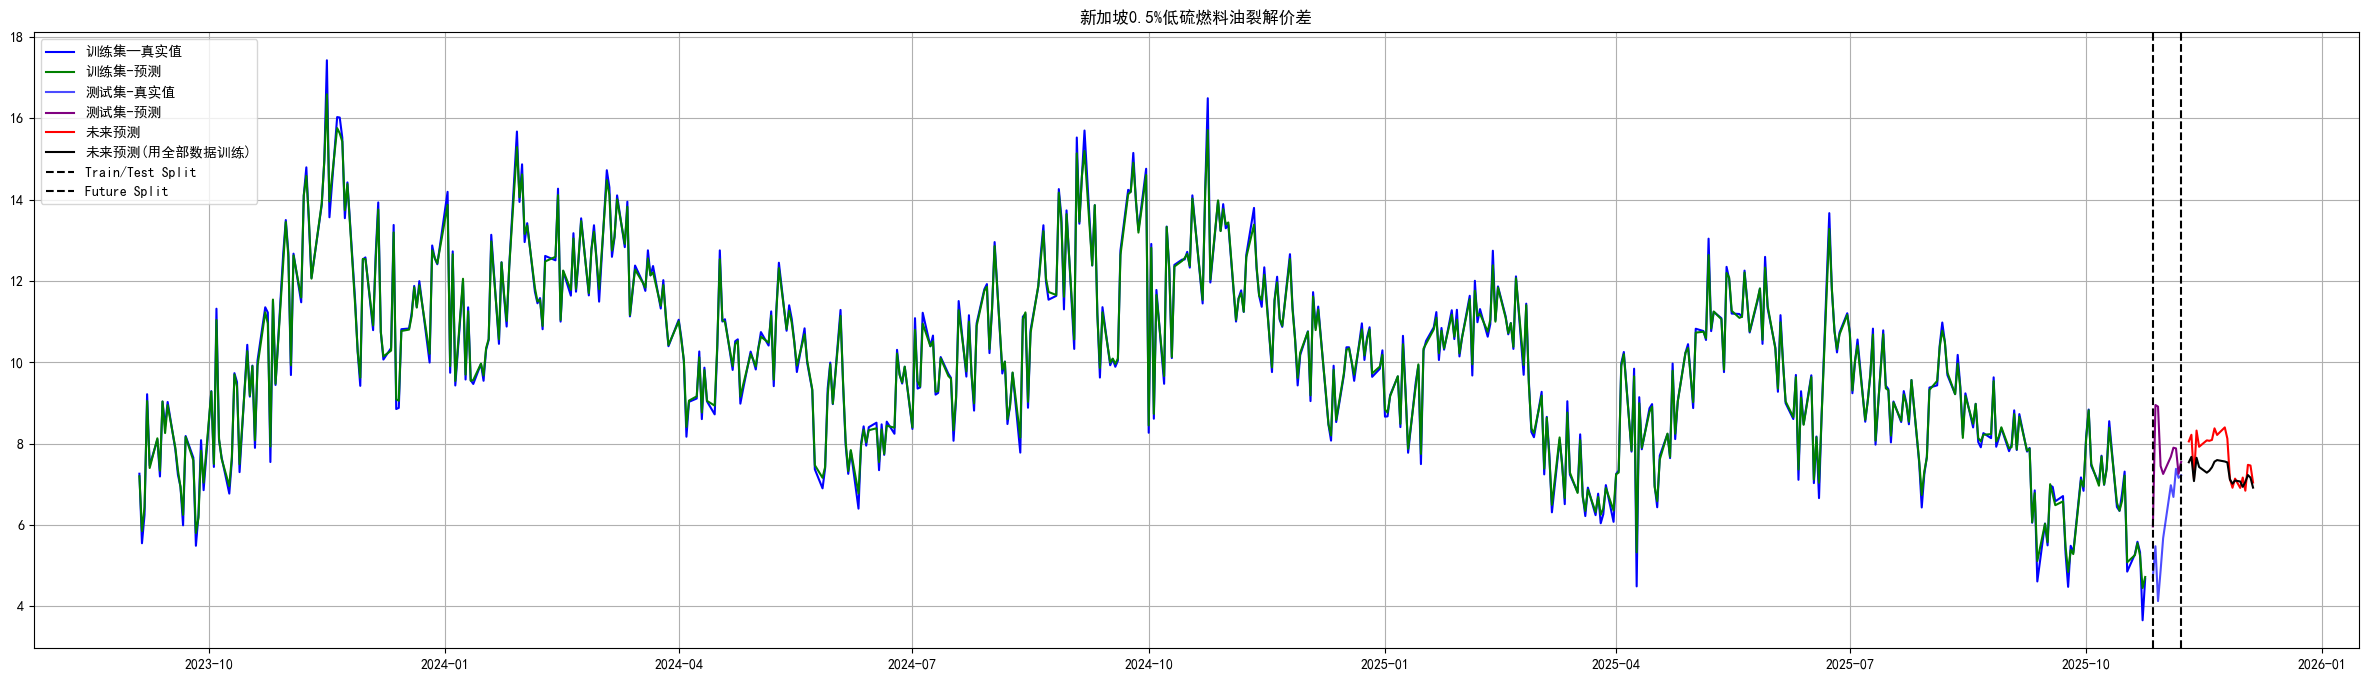

In [19]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('新加坡0.5%低硫燃料油裂解价差')
plt.legend()
plt.grid(True)
plt.show()

---

In [20]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx', index=False,float_format='%.2f')

merged_df_daily

,Date,真实值,预测值
584,2025/12/05,NaN,6.918259
583,2025/12/04,NaN,7.164063
582,2025/12/03,NaN,7.227078
581,2025/12/02,NaN,7.056818
580,2025/12/01,NaN,6.937063
...,...,...,...
4,2023/09/08,7.4602,NaN
3,2023/09/07,9.2139,NaN
2,2023/09/06,6.2504,NaN
1,2023/09/05,5.5506,NaN


In [21]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.dropna(subset=['真实值', '预测值'], how='all')
# 保存成excel
merged_df_monthly.to_excel('eta/新加坡0.5%低硫燃料油裂解价差_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
27,2025/12/31,NaN,7.060657
26,2025/11/30,7.085440,7.439178
25,2025/10/31,6.228561,6.842014
24,2025/09/30,6.714359,6.733539
23,2025/08/31,9.067390,9.066373


In [22]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.燃料油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "新加坡0.5%低硫燃料油裂解价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [23]:
from Lcel import update_excel_data
file_path = "eta/1.燃料油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "新加坡0.5%低硫燃料油裂解价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
